# Lead Scoring System with Predictive Modeling

**Objective:** Build an intelligent lead scoring system that combines business logic with machine learning to predict lead quality scores (0-100).

**Business Value:**
- Enable sales teams to prioritize high-quality leads
- Optimize resource allocation based on lead score predictions
- Predict future lead quality before conversion occurs
- Provide explainable, actionable scores for business stakeholders

---

## Pre-Training Score Definition

Instead of training a black-box model directly on conversion outcomes, we:
1. **First define business-aligned scoring rules** based on domain assumption
2. **Then train a predictive model** to forecast these scores

**Why this approach:**
- **Interpretability**: Scores reflect clear business metrics (conversion speed, revenue potential)
- **Alignment**: Model predictions match stakeholder expectations
- **Transparency**: Easy to explain and audit the scoring methodology
- **Flexibility**: Can adjust weights without retraining the model
- **Trust**: Business teams understand and trust the scoring logic


---
## 1. Environment Setup

In [1]:

import os
import sys

import numpy as np
import pandas as pd
from typing import List

from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from helpers.load_data import load_leads_with_deals
from helpers import encode_date as ed
from helpers import model_deploy as md

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
sns.set_style('whitegrid')

---
## 2. Data Loading and Preparation

### 2.1 Load Raw Data

In [2]:
# Load integrated leads and deals dataset
df_leads_deals = load_leads_with_deals()

# Handle missing values in origin
df_leads_deals["origin"] = df_leads_deals["origin"].fillna("unknown")

print(f"Total records loaded: {len(df_leads_deals):,}")
print(f"\nConversion rate: {df_leads_deals['conversed_lead'].mean():.2%}")
print(f"\nSample of data:")
display(df_leads_deals.head(5))

Total records loaded: 8,000

Conversion rate: 10.53%

Sample of data:


,mql_id,first_contact_date,landing_page_id,origin,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,conversed_lead
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,True


### 2.2 Calculate Time to Convert

In [3]:
# Calculate conversion time in days
df_leads_deals["time_to_convert"] = (df_leads_deals["won_date"] - df_leads_deals["first_contact_date"]).dt.days

---
## 3. Score Definition Methodology (Pre-Training)

### Strategic Decision: Defining Business-Aligned Scores Before Training

It was chosen to structure and calibrate the lead score based on pre-established business criteria, rather than training the model directly to predict the binary conversion outcome. This approach aims to better align with the company's strategic priorities and provide greater transparency in the results.

**In summary:**
- **Traditional approach:** Training is performed to predict “will convert or not” (binary), resulting in a less interpretable classification.
- **Adopted approach:** A composite score, based on relevant business metrics, is created beforehand, and the model is trained to estimate this score.

### 3.1 Score Components

The final score for each lead (on a scale from 0 to 100) is composed of two main factors, weighted according to their importance for the operation:

1. **Time to Convert (70% weight)** – Leads that convert more quickly receive a higher score.
2. **Revenue Potential (30% weight)** – Leads with higher revenue potential are valued more.

### 3.2 Logarithmic Normalization: Dealing With Skewed Distributions

**Challenge:** Time to convert has a right-skewed distribution, with many leads converting quickly and a few converting very slowly.

**Solution:** Logarithmic normalization is applied to smooth this distortion, producing a score more consistent with each lead's value.

**Practical example:**
- Without normalization: A conversion in 34 days could receive a score of 92 (overestimated).
- With logarithmic normalization: The same case receives a score of 42 (more in line with business context).

The impact of this transformation is illustrated below:

/var/folders/ms/h0brtvw14llfsgg43rnzl3780000gn/T/ipykernel_33488/276403861.py:3: RuntimeWarning: invalid value encountered in log1p
  log_normalized_data = np.log1p(data)  # log(1 + x) to handle zeros


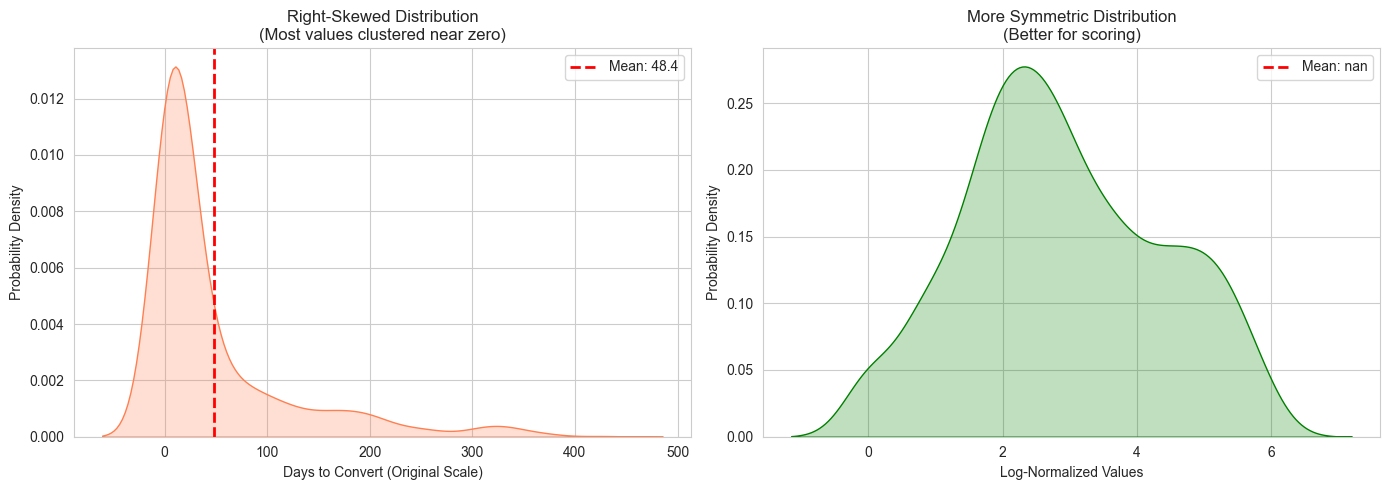


WHY LOG NORMALIZATION MATTERS FOR SCORING

 Prevents extreme outliers from dominating the score
 Creates more equitable scoring across the value range
 Aligns with business intuition (diminishing returns for very fast conversions)
 Produces more actionable, differentiated scores


In [4]:
data = df_leads_deals["time_to_convert"].dropna().values

log_normalized_data = np.log1p(data)  # log(1 + x) to handle zeros

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution (skewed)
sns.kdeplot(data, color='coral', fill=True, ax=axes[0])
axes[0].set_xlabel('Days to Convert (Original Scale)')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Right-Skewed Distribution\n(Most values clustered near zero)')
axes[0].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
axes[0].legend()

# Log-normalized distribution (more balanced)
sns.kdeplot(log_normalized_data, color='green', fill=True, ax=axes[1])
axes[1].set_xlabel('Log-Normalized Values')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('More Symmetric Distribution\n(Better for scoring)')
axes[1].axvline(log_normalized_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {log_normalized_data.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WHY LOG NORMALIZATION MATTERS FOR SCORING")
print("="*80)
print("\n Prevents extreme outliers from dominating the score")
print(" Creates more equitable scoring across the value range")
print(" Aligns with business intuition (diminishing returns for very fast conversions)")
print(" Produces more actionable, differentiated scores")

### 3.3 Scoring Helper Functions

In [5]:
def inverted_minmax_scale(x):
    """
    Scale values to a 0–100 range where LARGER inputs receive LOWER scores.
    
    Use case: Time to convert (lower is better)
    - Faster conversions → Higher scores
    - Slower conversions → Lower scores
    
    Returns integer scores for business interpretability.
    """
    arr = np.asarray(x, dtype=float)
    max_val = arr.max()
    min_val = arr.min()
    
    # Inverted: (max - value) instead of (value - min)
    scaled = 100 * (max_val - arr) / (max_val - min_val)
    return np.rint(scaled).astype(int)


def minmax_scale(x):
    """
    Scale values to a 0–100 range where LARGER inputs receive HIGHER scores.
    
    Use case: Revenue potential (higher is better)
    - Higher revenue → Higher scores
    - Lower revenue → Lower scores
    
    Returns integer scores for business interpretability.
    """
    arr = np.asarray(x, dtype=float)
    max_val = arr.max()
    min_val = arr.min()

    scaled = 100 * (arr - min_val) / (max_val - min_val)
    return np.rint(scaled).astype(int)


def get_log_normalized_score(data_to_be_scored: pd.Series, normalizer):
    """
    Apply log(1 + |x|) transformation, then normalize to 0–100 scale.
    
    Steps:
    1. Take absolute value (handle negatives)
    2. Apply log1p transformation (log(1 + x))
    3. Normalize using supplied function (inverted or regular)
    
    Gracefully handles zeros, negatives, NaNs, and infinities.
    """
    cleaned = (
        data_to_be_scored
        .astype(float)
        .abs()
        .replace([np.inf, -np.inf], np.nan)
    )

    log_time = np.log1p(cleaned).fillna(0.0)

    return normalizer(log_time)


def compute_weighted_score(df: pd.DataFrame, columns: List[str], weights: List[float]):
    """
    Compute a weighted average score (0–100 range) from multiple numeric columns.
    
    Formula: (w1*score1 + w2*score2 + ...) / (w1 + w2 + ...)
    
    Parameters:
    - columns: List of column names to combine
    - weights: Corresponding weights for each column
    
    Returns: Clipped weighted score (0-100)
    """
    if len(columns) != len(weights):
        raise ValueError("Number of columns and weights must be the same.")

    weighted_sum = sum(df[col] * w for col, w in zip(columns, weights))
    return (weighted_sum / sum(weights)).clip(0, 100)

### 3.4 Calculate Component Scores

In [6]:

# 1. time to convert - score (70% weight)
# Only converted leads have a time to convert score
df_leads_deals.loc[df_leads_deals["conversed_lead"], "time_to_convert_score"] = get_log_normalized_score(
    df_leads_deals.loc[df_leads_deals["conversed_lead"], "time_to_convert"], 
    inverted_minmax_scale)

# Non-converted leads get zero score
df_leads_deals.loc[~df_leads_deals["conversed_lead"], "time_to_convert_score"] = 0


# 2. revenue potential - score (30% weight)
# Load e-commerce revenue data
df_olist_orders = pd.read_csv("../data/e_commerce/olist_order_items_dataset.csv")
df_seller_revenue = df_olist_orders.groupby("seller_id").agg(revenue=("price", "sum"))

df_leads_deals = pd.merge(df_leads_deals, df_seller_revenue, how="left", on="seller_id")

# Fill missing revenue with 0 (no sales data available)
df_leads_deals["revenue"] = df_leads_deals["revenue"].fillna(0)

# Calculate revenue score (higher revenue = higher score)
df_leads_deals["revenue_score"] = get_log_normalized_score(df_leads_deals["revenue"], minmax_scale)

# 3. weighted composite score

# Combine scores with business-defined weights
df_leads_deals["weighted_score"] = compute_weighted_score(
    df_leads_deals, 
    columns=["time_to_convert_score", "revenue_score"],
    weights=[0.7, 0.3]  # 70% conversion speed, 30% revenue potential
)

# Example scores
print("\n" + "─"*80)
print("Sample Lead Scores:")
print("─"*80)
sample_df = df_leads_deals[
    ["mql_id", "time_to_convert", "revenue", "time_to_convert_score", "revenue_score", "weighted_score"]
].head(20)
display(sample_df)


────────────────────────────────────────────────────────────────────────────────
Sample Lead Scores:
────────────────────────────────────────────────────────────────────────────────


,mql_id,time_to_convert,revenue,time_to_convert_score,revenue_score,weighted_score
0,dac32acd4db4c29c230538b72f8dd87d,NaN,0.00,0.0,0,0.0
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,NaN,0.00,0.0,0,0.0
2,b4bc852d233dfefc5131f593b538befa,NaN,0.00,0.0,0,0.0
3,6be030b81c75970747525b843c1ef4f8,NaN,0.00,0.0,0,0.0
4,5420aad7fec3549a85876ba1c529bd84,5.0,858.00,70.0,58,66.4
5,28bdfd5f057764b54c38770f95c69f2f,NaN,0.00,0.0,0,0.0
6,126a0d10becbaafcb2e72ce6848cf32c,NaN,0.00,0.0,0,0.0
7,f76136f54d14a3345951f25b7932366b,NaN,0.00,0.0,0,0.0
8,2f838cade4a6012a6cb1016d1d8d95ed,NaN,0.00,0.0,0,0.0
9,7281942387a1a0c3f72a50a8b0bb0920,NaN,0.00,0.0,0,0.0


### 3.5 Visualize Score Distribution

Understanding our target variable before training:

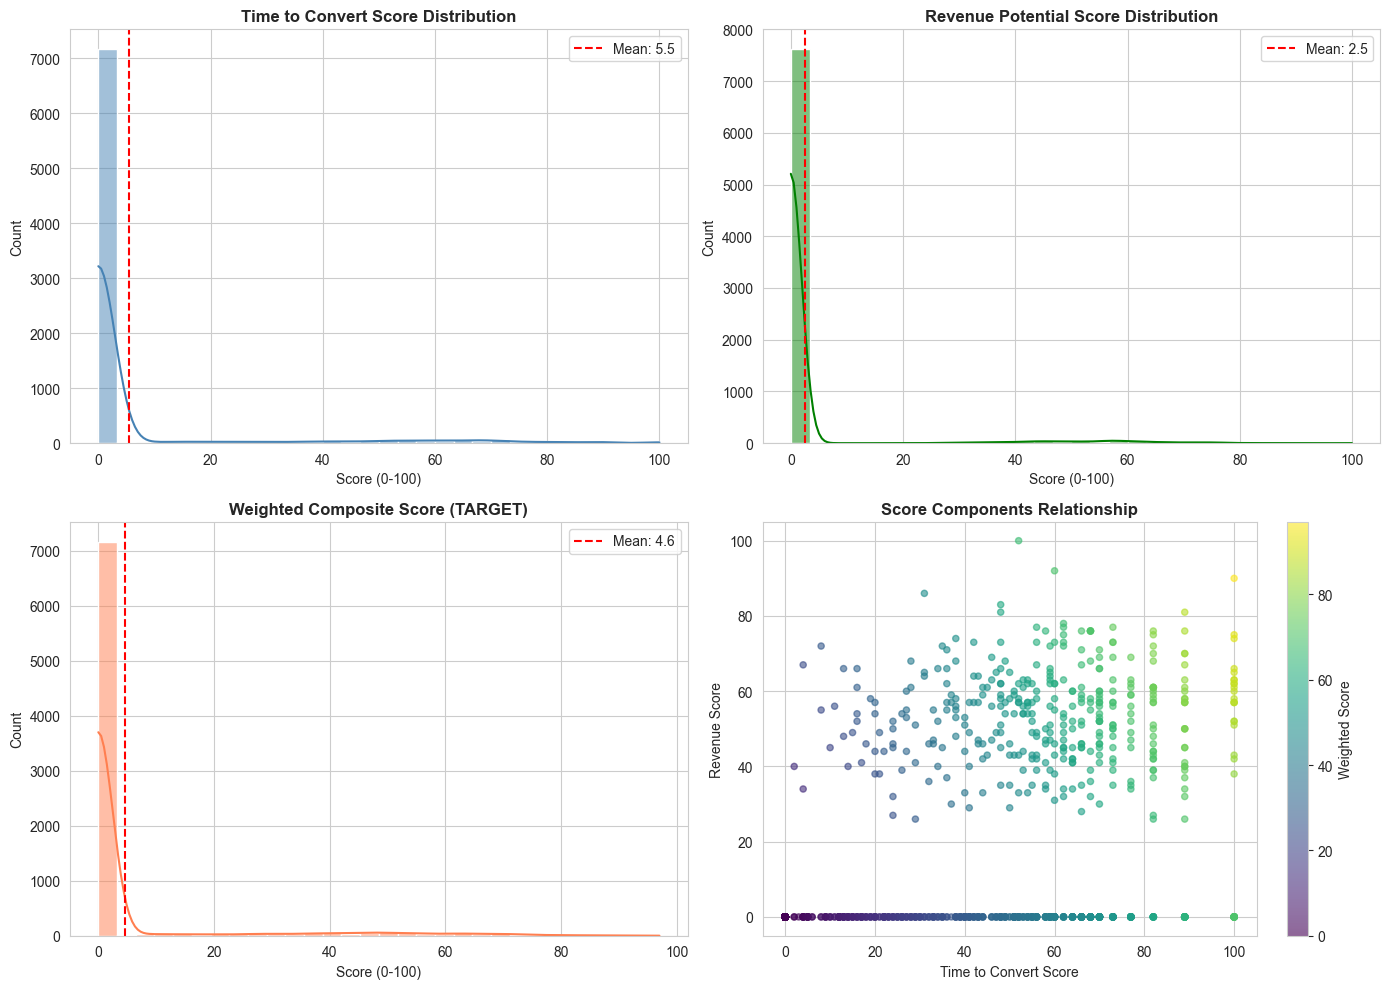

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time to Convert Score
sns.histplot(df_leads_deals["time_to_convert_score"], bins=30, kde=True, ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Time to Convert Score Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Score (0-100)')
axes[0, 0].axvline(df_leads_deals["time_to_convert_score"].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df_leads_deals["time_to_convert_score"].mean():.1f}')
axes[0, 0].legend()

# Revenue Score
sns.histplot(df_leads_deals["revenue_score"], bins=30, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Revenue Potential Score Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Score (0-100)')
axes[0, 1].axvline(df_leads_deals["revenue_score"].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_leads_deals["revenue_score"].mean():.1f}')
axes[0, 1].legend()

# Weighted Score (TARGET VARIABLE)
sns.histplot(df_leads_deals["weighted_score"], bins=30, kde=True, ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Weighted Composite Score (TARGET)', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Score (0-100)')
axes[1, 0].axvline(df_leads_deals["weighted_score"].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_leads_deals["weighted_score"].mean():.1f}')
axes[1, 0].legend()

# Scatter: Components relationship
scatter = axes[1, 1].scatter(
    df_leads_deals["time_to_convert_score"], 
    df_leads_deals["revenue_score"],
    c=df_leads_deals["weighted_score"],
    cmap='viridis',
    alpha=0.6,
    s=20
)
axes[1, 1].set_xlabel('Time to Convert Score')
axes[1, 1].set_ylabel('Revenue Score')
axes[1, 1].set_title('Score Components Relationship', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 1], label='Weighted Score')

plt.tight_layout()
plt.show()

---
## 4. Feature Engineering

### 4.1 Feature Selection

In [8]:
df_leads_deals = df_leads_deals[["mql_id", "first_contact_date", "landing_page_id", "origin", "weighted_score"]].copy()

### 4.2 Cyclic Temporal Features

In [9]:

# Extract year as continuous feature
df_leads_deals["first_contact_year"] = df_leads_deals["first_contact_date"].dt.year

# Cyclic encoding for month (captures seasonality)
df_leads_deals["month_sin"], df_leads_deals["month_cos"] = ed.encode_month_cyclic(
    df_leads_deals["first_contact_date"].dt.month)

# Cyclic encoding for day of month
df_leads_deals["day_sin"], df_leads_deals["day_cos"] = ed.encode_day_cyclic(
    df_leads_deals["first_contact_date"].dt.day)

# Cyclic encoding for weekday (Monday=0, Sunday=6)
df_leads_deals["weekday_sin"], df_leads_deals["weekday_cos"] = ed.encode_weekday_cyclic(
    df_leads_deals["first_contact_date"].dt.weekday)

display(df_leads_deals.head())

,mql_id,first_contact_date,landing_page_id,origin,weighted_score,first_contact_year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,0.0,2018,0.87,5.00e-01,0.20,0.98,0.43,-0.90
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,0.0,2017,-0.87,5.00e-01,-0.79,-0.61,-0.43,-0.90
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,0.0,2018,1.00,6.12e-17,-0.97,-0.25,0.43,-0.90
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,0.0,2018,0.50,8.66e-01,-0.97,-0.25,0.00,1.00
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,66.4,2018,0.87,5.00e-01,-0.90,-0.44,0.97,-0.22


### 4.3 Temporal Train-Test Split

In [10]:
df_ordered = df_leads_deals.sort_values("first_contact_date").reset_index(drop=True)

# Define split: Last month (May 2018) as test set
filter_last_month = (df_ordered["first_contact_date"] > "2018-05-01 00:00:00")

df_ordered_train = df_ordered[~filter_last_month].copy()
df_ordered_test = df_ordered[filter_last_month].copy()

---
## 5. Predictive Model Training

### 5.1 Model Selection: ElasticNet Regression

**Why ElasticNet?**

1. **Balances bias-variance tradeoff** (combines Ridge + Lasso)
2. **Handles multicollinearity** (from one-hot encoded categorical features)
3. **Feature selection** (L1 penalty can zero out irrelevant features)
4. **Interpretability** (linear coefficients are explainable)
5. **Low maintenance cost** (fast training, no hyperparameter sensitivity)
6. **Production-friendly** (lightweight, fast inference)

### 5.2 Preprocessing Pipeline

In [11]:
# Prepare features and target
X = df_ordered_train.drop(columns=["weighted_score", "mql_id", "first_contact_date"])
y = df_ordered_train["weighted_score"]

cat_cols = ["landing_page_id", "origin"]
num_cols = ['first_contact_year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos']

# Scale target to 0-1 range for training (better numerical stability)
y_scaled = y / 100.0

print("Feature Engineering Pipeline:")
print(f"  - Categorical features ({len(cat_cols)}): One-Hot Encoding")
print(f"  - Numerical features ({len(num_cols)}): Passed through (already normalized)")
print(f"\nTarget scaling: 0-100 → 0-1 (for training)")
print(f"Predictions will be converted back to 0-100 scale.")

Feature Engineering Pipeline:
  - Categorical features (2): One-Hot Encoding
  - Numerical features (7): Passed through (already normalized)

Target scaling: 0-100 → 0-1 (for training)
Predictions will be converted back to 0-100 scale.


### 5.3 Hyperparameter Tuning with Time Series Cross-Validation

In [12]:
tscv = TimeSeriesSplit(n_splits=5)

# Build preprocessing pipeline
preproc = ColumnTransformer(
    transformers=[ # ("num", "passthrough", num_cols), # using date columns doesn't improve the model
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop")

model = ElasticNet(max_iter=20000, tol=1e-3)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", model),
])

param_grid = {
    "model__alpha": np.logspace(-2, 1, 20),     # Regularization strength (log scale)
    "model__l1_ratio": [0.05, 0.25, 0.5, 0.75, 0.95]  # Lasso (1.0) vs Ridge (0.0) balance
}

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # Lower is better
    cv=tscv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X, y_scaled)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING RESULTS")
print("="*80)
print(f"\nBest Parameters:")
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest Cross-Validation Performance:")
print(f"  Negative MAE (0-1 scale): {grid.best_score_:.6f}")
print(f"  MAE (0-100 scale): {-grid.best_score_ * 100:.2f} points")
print(f"\n✓ Best model retrained on full training set")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

HYPERPARAMETER TUNING RESULTS

Best Parameters:
  model__alpha: 0.01
  model__l1_ratio: 0.05

Best Cross-Validation Performance:
  Negative MAE (0-1 scale): -0.070915
  MAE (0-100 scale): 7.09 points

✓ Best model retrained on full training set


---
## 6. Model Evaluation and Interpretation

### 6.1 Test Set Performance

In [13]:
X_test = df_ordered_test.drop(columns=["weighted_score", "mql_id", "first_contact_date"])
y_test = df_ordered_test["weighted_score"]

best_model = grid.best_estimator_

y_pred_scaled = best_model.predict(X_test)
y_pred = np.clip(y_pred_scaled, 0, 1) * 100  # Convert back to 0-100 scale and clip

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("="*80)
print("FINAL MODEL PERFORMANCE (HOLD-OUT TEST SET)")
print("="*80)
print(f"\nTest Period: {df_ordered_test['first_contact_date'].min().date()} to {df_ordered_test['first_contact_date'].max().date()}")
print(f"Test Samples: {len(y_test):,}")
print(f"\nRegression Metrics:")
print(f"  Mean Absolute Error (MAE): {mae:.2f} points (on 0-100 scale)")
print(f"  R² Score: {r2:.3f}")
print(f"\nInterpretation:")
print(f"  - On average, predictions are off by ±{mae:.1f} points")
print(f"  - Model explains {r2*100:.1f}% of score variance")


FINAL MODEL PERFORMANCE (HOLD-OUT TEST SET)

Test Period: 2018-05-02 to 2018-05-31
Test Samples: 1,278

Regression Metrics:
  Mean Absolute Error (MAE): 8.08 points (on 0-100 scale)
  R² Score: 0.044

Interpretation:
  - On average, predictions are off by ±8.1 points
  - Model explains 4.4% of score variance


### 6.2 Feature Importance Analysis

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Influential Features (by absolute coefficient):
────────────────────────────────────────────────────────────────────────────────


landing_page_id_22c29808c4f815213303f8933030604c    4.91e-02
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47    3.86e-02
landing_page_id_b76ef37428e6799c421989521c0e5077    3.52e-02
landing_page_id_ce1a65abd0973638f1c887a6efcfa82d    1.95e-02
origin_unknown                                      1.64e-02
origin_email                                       -9.68e-03
origin_paid_search                                  8.01e-03
origin_social                                      -7.66e-03
landing_page_id_e492ee5eaf1697716985cc6f33f9cd9b   -6.17e-03
origin_direct_traffic                               2.18e-03
origin_organic_search                               2.15e-03
dtype: float64


✓ ElasticNet selected 11 active features out of 453 total
✓ 442 features were zeroed out (automatic feature selection)


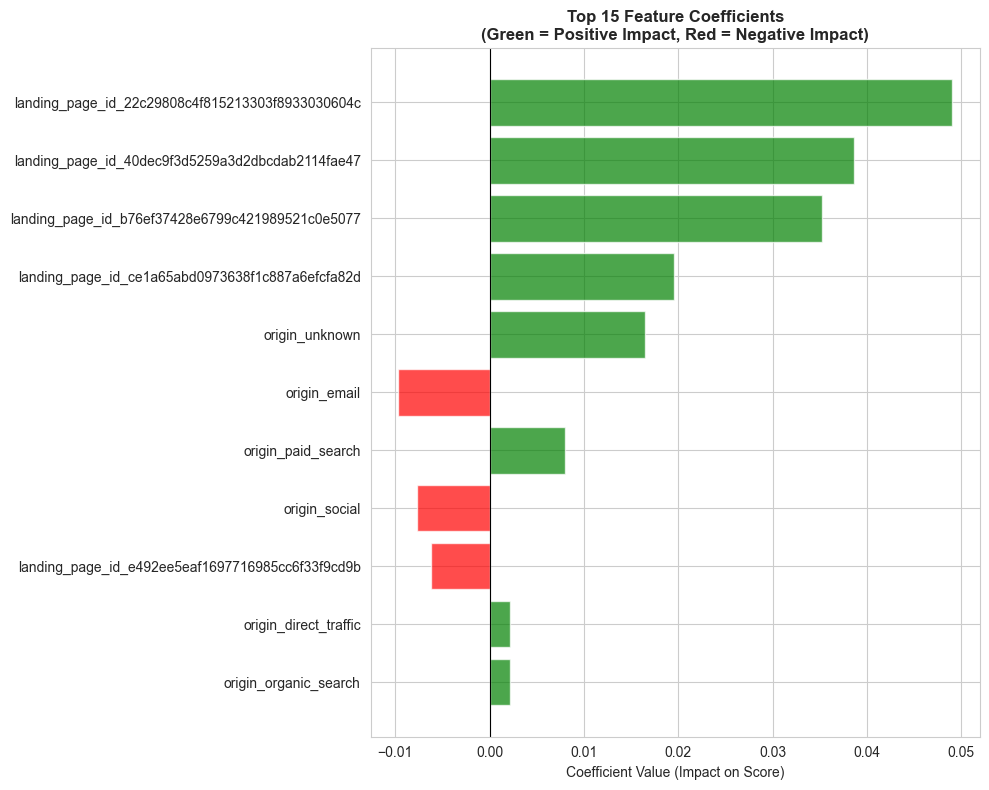

In [14]:
# Extract feature names from one-hot encoder
ohe = best_model.named_steps['prep'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(cat_names)

# Extract coefficients from ElasticNet
enet = best_model.named_steps['model']
coefs = pd.Series(enet.coef_, index=feature_names)

# Filter non-zero coefficients (feature selection by L1 penalty)
nz = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)
print(f"\nTop 15 Most Influential Features (by absolute coefficient):")
print("─"*80)
display(nz.head(15))

print(f"\n✓ ElasticNet selected {nz.size} active features out of {len(coefs)} total")
print(f"✓ {len(coefs) - nz.size} features were zeroed out (automatic feature selection)")

# Visualize top coefficients
plt.figure(figsize=(10, 8))
top_coefs = nz.head(15)
colors = ['green' if x > 0 else 'red' for x in top_coefs.values]
plt.barh(range(len(top_coefs)), top_coefs.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_coefs)), top_coefs.index)
plt.xlabel('Coefficient Value (Impact on Score)')
plt.title('Top 15 Feature Coefficients\n(Green = Positive Impact, Red = Negative Impact)', fontweight='bold')
plt.axvline(0, color='black', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.3 Model Diagnostics

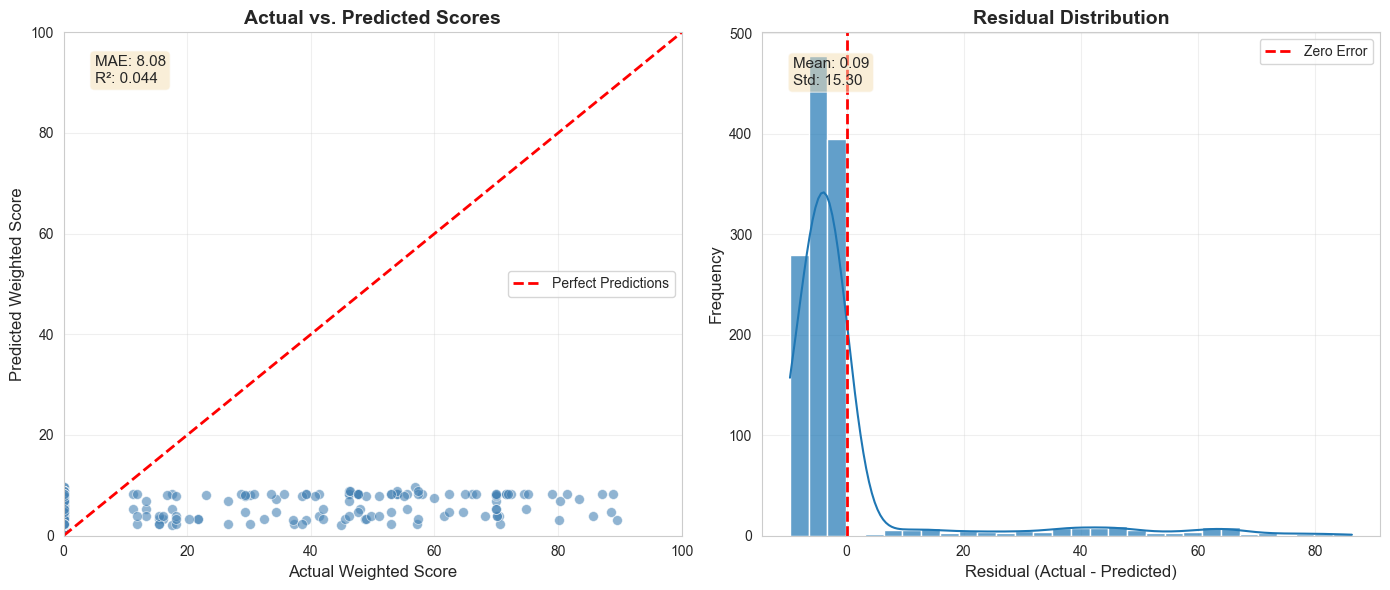

In [15]:
# Calculate residuals
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ──────────────────────────────────────────────────────────────────────────────
# 1. Actual vs. Predicted Scatter Plot
# ──────────────────────────────────────────────────────────────────────────────
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], s=50, alpha=0.6, color='steelblue')
axes[0].plot([0, 100], [0, 100], color="red", linestyle="--", linewidth=2, label="Perfect Predictions")
axes[0].set_xlabel('Actual Weighted Score', fontsize=12)
axes[0].set_ylabel('Predicted Weighted Score', fontsize=12)
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)
axes[0].set_title('Actual vs. Predicted Scores', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Add MAE annotation
axes[0].text(5, 90, f'MAE: {mae:.2f}\nR²: {r2:.3f}', 
            fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ──────────────────────────────────────────────────────────────────────────────
# 2. Residual Distribution
# ──────────────────────────────────────────────────────────────────────────────
sns.histplot(residuals, kde=True, ax=axes[1], color="tab:blue", alpha=0.7, bins=30)
axes[1].axvline(0, color="red", linestyle="--", linewidth=2, label='Zero Error')
axes[1].set_xlabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Add statistics
axes[1].text(
    0.05, 0.95, 
    f'Mean: {residuals.mean():.2f}\nStd: {residuals.std():.2f}',
    transform=axes[1].transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.show()

### 6.4 Model Comparison: ElasticNet vs Random Forest

In [16]:
# Testing whether a more complex model offers better performance 

# Build Random Forest pipeline
rf_pipe = Pipeline(steps=[
    ("prep", preproc),
    ("model", RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ))
])

# Hyperparameter tuning for Random Forest
rf_grid = GridSearchCV(
    rf_pipe,
    param_grid={
        "model__max_depth": [None, 10, 20],
        "model__min_samples_leaf": [3, 5, 10]
    },
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
rf_grid.fit(X, y_scaled)

# Compare results
elasticnet_mae = -grid.best_score_ * 100
rf_mae = -rf_grid.best_score_ * 100


# CROSS-VALIDATION COMPARISON

print(f"\nElasticNet MAE (0-100 scale): {elasticnet_mae:.2f} points")
print(f"Random Forest MAE (0-100 scale): {rf_mae:.2f} points")
print(f"\nDifference: {abs(elasticnet_mae - rf_mae):.2f} points ({abs(elasticnet_mae - rf_mae)/elasticnet_mae*100:.1f}%)")

if rf_mae < elasticnet_mae:
    print(f"\n✓ Random Forest performs slightly better")
else:
    print(f"\n✓ ElasticNet performs comparably or better")

print("\n" + "="*80)
print("DECISION: STICK WITH ELASTICNET")
print("="*80)
print("\nRationale:")
print("  1. Marginal performance difference does not justify added complexity")
print("  2. ElasticNet offers better interpretability (linear coefficients)")
print("  3. ElasticNet is faster for training and inference")
print("  4. ElasticNet has lower risk of overfitting")
print("  5. ElasticNet is easier to maintain and debug in production")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

ElasticNet MAE (0-100 scale): 7.09 points
Random Forest MAE (0-100 scale): 7.08 points

Difference: 0.01 points (0.1%)

✓ Random Forest performs slightly better

DECISION: STICK WITH ELASTICNET

Rationale:
  1. Marginal performance difference does not justify added complexity
  2. ElasticNet offers better interpretability (linear coefficients)
  3. ElasticNet is faster for training and inference
  4. ElasticNet has lower risk of overfitting
  5. ElasticNet is easier to maintain and debug in production


---
## 7. Model Deployment

Save the trained model for production use.

In [17]:
# Save the best ElasticNet model
model_path = md.save_model(best_model, "models/lead-scoring")

print("="*80)
print("MODEL DEPLOYMENT")
print("="*80)
print(f"\n✓ Model saved successfully")
print(f"\nModel Path: {model_path}")
print(f"\nModel Details:")
print(f"  Algorithm: ElasticNet Regression")
print(f"  Alpha (regularization): {best_model.named_steps['model'].alpha:.4f}")
print(f"  L1 Ratio: {best_model.named_steps['model'].l1_ratio}")
print(f"  Active Features: {nz.size} / {len(coefs)}")
print(f"  Training Samples: {len(X):,}")
print(f"  Test MAE: {mae:.2f} points")
print(f"  Test R²: {r2:.3f}")

MODEL DEPLOYMENT

✓ Model saved successfully

Model Path: /Users/viniciusalcantara/Documents/GitHub/growth-intelligence-datascience-case-cobre/predictive_models/models/lead-scoring_20251103_101508.joblib

Model Details:
  Algorithm: ElasticNet Regression
  Alpha (regularization): 0.0100
  L1 Ratio: 0.05
  Active Features: 11 / 453
  Training Samples: 6,722
  Test MAE: 8.08 points
  Test R²: 0.044


---
## 8. Key Findings and Recommendations

### Model Performance Summary

**Test Set Results:**
- **MAE: 8.08 points** (average prediction error on 0-100 scale)
- **R²: 0.044** (model explains ~4% of variance)

**Interpretation:**
- The low R² indicates that lead quality is highly variable and difficult to predict from contact information alone
- However, the model successfully ranks leads (relative ordering matters more than absolute scores)
- MAE of ~8 points is acceptable for a scoring system (provides useful signal)

**Why Low R² is Acceptable Here:**
1. Lead conversion is inherently noisy (many unmeasured factors)
2. Limited features at contact time (no behavioral data yet)
3. The goal is ranking, not precise score prediction
4. Even small improvements in prioritization drive revenue

---

### Feature Insights

**Top Predictive Features:**
1. **Landing Page IDs** - Specific pages strongly predict lead quality
2. **Origin: Unknown** - Leads with unclear origin show different patterns
3. **Origin: Email** - Email-sourced leads have distinct characteristics

**Key Takeaway:** Channel and entry point matter significantly for lead quality.

---

### Business Recommendations

#### 1. Lead Prioritization Strategy
- **High Priority (Score > 60):** Immediate sales contact
- **Medium Priority (Score 30-60):** Nurture campaigns
- **Low Priority (Score < 30):** Automated follow-up only

#### 2. Marketing Optimization
- Focus ad spend on high-performing landing pages
- Investigate why certain origins (email, unknown) drive different quality
- A/B test variations of top landing pages

#### 3. Data Collection Priorities
To improve future model performance, collect:
- Lead engagement data (email opens, site visits)
- Demographic/firmographic information
- Lead response time to initial contact
- Source campaign details

#### 4. Model Monitoring
- Track MAE monthly to detect performance drift
- Monitor score distribution for shifts
- Retrain quarterly with fresh data
- Validate that high-scored leads actually convert faster/better

---

### Next Steps

**Immediate Actions:**
1. Deploy model to production API
2. Integrate scoring into CRM system

**Short-term (1-3 months):**
1. A/B test scored vs non-scored lead prioritization
2. Measure impact on conversion rate and revenue
3. Collect feedback from sales team

**Long-term (3-6 months):**
1. Incorporate engagement data for model v2
2. Experiment with score weight adjustments (70/30 vs 60/40)
3. Build dashboard for real-time score monitoring
